# HFRX Global Hedge Fund Index Replication
by Doldi Filippo, Nodari Alessandro, Prosepio Lorenzo, Venturi Simone

We tried to replicate and forecast the HFRX Global Hedge Fund Index using only a dynamic portfolio made of 11 futures. In particolar we used the followings futures (tickers only): RX1, TY1, GC1, CO1, ES1, VG1, NQ1, LLL1, TP1, DU1, TU2.

### Loading the libraries and the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import minimize
from sklearn.covariance import OAS

data = pd.read_excel("InvestmentReplica.xlsx", sheet_name="Replica")
data.set_index('Date', inplace = True)

df = pd.DataFrame(np.log(data.iloc[:,4:]).diff(1).dropna())
target = pd.DataFrame(np.log(data['HFRXGL']).diff(1).dropna())

### Replication approach

#### The mathematical formulation:

To replicate the index at time $t$ we suppose to know the returns of both the futures and the index at time $t$ and the weights of our portfolio at time $t-1$. From now on we will use the following notations:

0) whenever we refer to returns we mean log-returns;

1) the vector of the weights of each futures in our portfolio at time $t$: $\textbf{w}_t=(w^1,...,w^{11})_t$;

2) the vector of the returns of each futures in our portfolio at time $t$: $\textbf{r}_t=(r^1,...,r^{11})_t$;

3) the return of the index at time $t$: $r_{ind_t}$;

and the following assumptions:

4) $C$ is a fixed constant which represents the trading cost in percentage per operation;

5) the sum of the absolute values of the weights at each time is $1$ (we allocate all the capital at each time, use no leverage and long-only);

6) at each time $t$ we want that the absolute difference between the returns of our portfolio and the index is controlled by a constant $toll$ (tollerance);

we want to:

7)  minimize at each time $t$ the trading cost to change the weights from $\textbf{w}_{t-1}$ to $\textbf{w}_{t}$.

Rewriting in mathematical terms the paragraph before: we want to solve for $\textbf{w}_t$, step by step by time, the following constrained minimization problem:

$$(\star)\;\;\;\;\min\bigg\{C \sum_{j = 1}^{11}\big(w_t^j-w_{t-1}^j\big)^2\, \text{:  constrained with }\bigg(\sum_{j = 1}^{11}w_t^jr_t^j - r_{ind_t}\bigg)^2 < toll \text{,}\,\sum_{j = 1}^{11}w_t^j=1 \text{, } \forall j \,\, 1 > w_t^j > 0\bigg\}$$

this is a convex problem with convex constraints that can be solved using the KKT method.

#### Choice of the starting vector of weights

The only issue that remains to solve is how to choose the first vector of weights. To do that we used the first 200 observations to estimate the covariance matrix (called $\Sigma$) of the returns and choose the portfolio that solves the following constrained minimization problem:

$$\min\bigg\{ \textbf{w}_0 \Sigma \textbf{w}_0^T \, \text{:  constrained with }\sum_{j = 1}^{11}w_0^jr_0^j = r_{ind_0} \text{,}\,\,\sum_{j = 1}^{11}w_t^j=1 \text{, } \forall j \,\, 1 > w_t^j > 0\bigg\}$$

in practice we choose the weights that gives us the portfolio which meets the return of the index and has minimum variance (we estimate the variance of the returns with the Oracle-Approximating Shrinkage estimator). Here we are looking into the future, but actually it does not matter since we start predicting from the 300th observation (so we treated the first 300 observations as a training set, it will be clear later).

#### The algorithm:

To sum up:

1) see the returns at time $0$ and set up a portfolio as explained above;

2) from this we choose the weights $(w^1,w^2,...,w^{11})_1$ as the solution of the problem $(\star)$;

3) we reiterate from the previous point to find  $(w^1,w^2,...,w^{11})_2$ and proceed by induction until the end.

#### Implementation of the minimization problem:

In [2]:
# the function we have to minimize

def objective(weights, old_weights, trading_cost):
    return np.dot(trading_cost * (weights - old_weights)**2, np.ones(11))

# the constrain 6) in the previous paragraphs in the form of function > 0

def constraint(weights, ret_fut, ret_index, threshold):
    return -(np.dot(weights, ret_fut) - ret_index)**2 + threshold

# the constrain 5) in the previous paragraphs in the form of function = 0

def constraint2(weights):
    return weights.sum() - 1 

# numerical solution of the problem using scipy.minimize  

def minimize_next(ret_fut, ret_index, old_weights, trading_cost, threshold):
    weights = old_weights
    con1 = {'type': 'ineq', 'fun': constraint, 'args': (ret_fut,ret_index, threshold)}
    con2 = {'type': 'eq', 'fun': constraint2, 'args': ()}
    b = (0.0,1.0)
    bnds = (b, b, b, b, b, b, b, b, b, b, b) 
    solution = minimize(objective,
                        weights,
                        args = (old_weights, trading_cost),
                        method='SLSQP',
                        constraints=(con1,con2),
                        tol = 1e-8,
                        bounds = bnds)
    weights = solution.x
    return weights

#### Implementation of the problem to choose the starting weights

In [3]:
# the function we have to minimize

def objective2(weights, Sigma):
    return np.dot(weights, np.dot(Sigma,weights))

# the constraint on the returns

def constraint3(weights, ret_fut, ret_index):
    return np.dot(weights, ret_fut) - ret_index

# the second constraint has been already implemented before 
# numerical solution of the problem using scipy.minimize  

def minimum_variance_ptf(ret_fut, ret_index, Sigma):
    #initial guess to start the algorithm
    weights = np.zeros(11)
    con1 = {'type': 'eq', 'fun': constraint2, 'args': ()}
    con2 = {'type': 'eq', 'fun': constraint3, 'args': (ret_fut,ret_index)}
    b = (0.0,1.0)
    bnds = (b, b, b, b, b, b, b, b, b, b, b) 
    solution = minimize(objective2,
                        weights,
                        args = (Sigma),
                        method='SLSQP',
                        constraints=(con1,con2),
                        bounds = bnds)
    weights = solution.x
    return weights

#### Initial portfolio

In [4]:
# estimate Sigma from the first 200 observations

oas = OAS().fit(df)
Sigma = oas.covariance_

# step 1) of the algorithm in the previous paragraphs. We initialize the weights.

ret_index = np.array(target.iloc[0])
ret_fut = np.array(df.iloc[0])

initial_guess = minimum_variance_ptf(ret_fut, ret_index, Sigma)

#### Implementation of the algorithm:

In [5]:
# defining the trading cost and the tollerance (threshold)

trading_cost = 0.0002
threshold = 1e-20

# keep track of the trading cost of the strat and the weights at each time

trading_cost_strat = 0
i = 1
weights_history = np.array([initial_guess])

# step 2) and 3) of the algorithm. We compute step by step the new weights solving the min problem

while i < df.shape[0]:
        
    old_weights = weights_history[-1]
    ret_index = np.array(target.iloc[i])
    ret_fut = np.array(df.iloc[i])
    
    weights = minimize_next(ret_fut, ret_index, old_weights, trading_cost, threshold)
    
    trading_cost_strat += np.dot(trading_cost * np.abs(weights - old_weights), np.ones(11))
    weights_history = np.vstack([weights_history, weights])
    i += 1

#### Visualization of the results

<IPython.core.display.Javascript object>


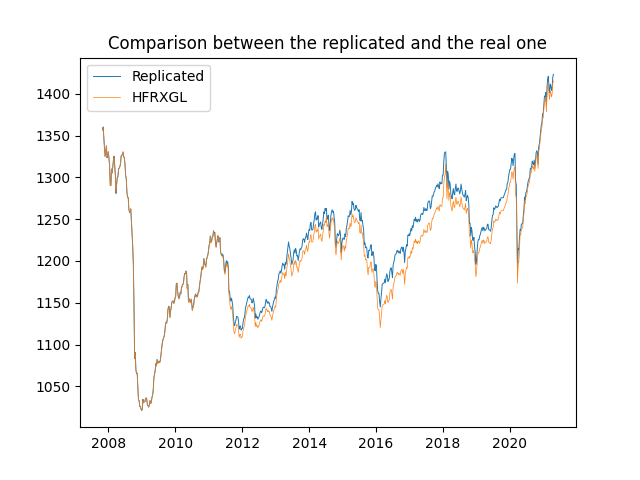

In [6]:
weights_history_cpy = weights_history
weights_history = pd.DataFrame(weights_history, columns = df.columns, index = df.index)

# calculate the log returns of our replication strategy
log_ret = np.array(0)
for index in weights_history.index:
    aux = np.array(weights_history.loc[index])
    aux_2 = np.array(df.loc[index])
    log_ret = np.vstack([log_ret, np.dot(aux,aux_2)])
    
log_ret = log_ret[1:]
weights_history['log_ret'] = log_ret 

# just plot

%matplotlib notebook

plt.plot(weights_history.index,
         np.exp(weights_history.log_ret.cumsum())*data.HFRXGL[0],
         lw = 0.7)
plt.plot(target.index, 
         np.exp(target.HFRXGL.cumsum())*data.HFRXGL[0],
         lw = 0.5)
plt.title('Comparison between the replicated and the real one')
plt.legend(['Replicated','HFRXGL'])
plt.show()

### Forecasting approach

After that we tried to find a way to forecast the weights at time $t$ knowing only the returns of the futures, the returns of the index and the weights of the replication strategy from the beginning until time $t-1$. In order to do that we used the exponential mean of the weights. The exponential mean, given a parameter $\lambda\in (0,1)$, is simply (given that we want to predict the weights at time $t$ and that the previous times are $t-1,t-2,...,1$):

$$\tilde{\textbf{w}}_{t,\lambda} = \sum^{t-1}_{j = 0} \lambda(1-\lambda)^j \textbf{w}_{t-1-j}$$

and then normalize it:

$$\hat{\textbf{w}}_{t,\lambda} = \dfrac{\tilde{\textbf{w}}_{t,\lambda}}{\lvert\lvert{\tilde{\textbf{w}}_{t,\lambda}}\rvert\rvert} $$

if we think about the parameter $\lambda$ we can see that higher $\lambda$ gives more importance to more recent weights, lower $\lambda$ gives more importance to the trend.



#### Tuning Lambda

However, we want $\lambda$ to be time-dependent (more market dependent), so we utilize the observation from 50 to 300 to build a dataset with the "optimal lambdas" for each step. The optimal lambdas are the lambdas which solves, for each time $t$:

$$\min_{\lambda\in(0,1)}\big|\big(\hat{\textbf{w}}_{t,\lambda} - \textbf{w}_t\big)\cdot \textbf{r}_t\big|$$

For simplicity's sake we search the "optimal lambdas" on a grid, not using again scipy.minimize.

In [7]:
# Definition of the exponential mean as explained above (plus an epsilon term just for numerical stability)

def exponential_mean(Lambda, Y):
    epsilon = 1e-16
    return Lambda*np.dot(np.geomspace((1-Lambda)**Y.shape[0]+epsilon,(1-Lambda), num=Y.shape[0]), Y)

Lambda_train = np.zeros(1)

# we search on a equispaced grid from 0.01 to 0.9 

Lambda_grid = np.linspace(0.01, 0.9, num = 50)

# building the train dataset

for i in range(50,300):
        
        err_minimum = 100000
        Lambda_best = 0.01
        
        for Lambda in Lambda_grid:
            
            expsmean = np.array(exponential_mean(Lambda,weights_history_cpy[:i,0])).reshape(1)
            j = 1
            while j < 11:
                expsmean_j = exponential_mean(Lambda,weights_history_cpy[:i,j]).reshape(1)
                expsmean = np.concatenate((expsmean, np.array(expsmean_j)))
                j += 1
            
            expsmean /= expsmean.sum()
            error = np.abs(np.dot(expsmean-weights_history_cpy[i,:],df.iloc[i]))
            if error < err_minimum:
                Lambda_best = Lambda
                err_minimum = error
        
        Lambda_train = np.vstack([Lambda_train,Lambda_best])

Lambda_train = Lambda_train[1:]

<IPython.core.display.Javascript object>


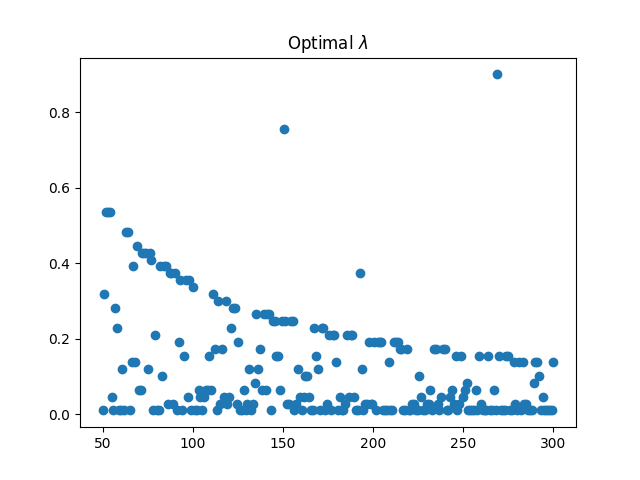

In [8]:
# visualization of the training set

%matplotlib notebook
plt.scatter(np.linspace(50,300,num = Lambda_train.shape[0]),Lambda_train)
plt.title('Optimal $\lambda$')
plt.show()

<IPython.core.display.Javascript object>


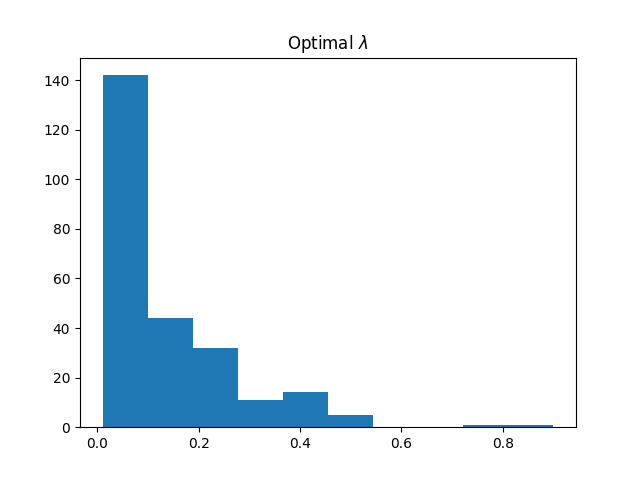

In [9]:
%matplotlib notebook
plt.hist(Lambda_train, bins = 10)
plt.title('Optimal $\lambda$')
plt.show()

We can see there are 2 "states": 

1) $\mu^1$ low lambda (~0.08);

2) $\mu^2$ high lambda (~ 0.15-0.5).

With $\mu^2$ that seems to decay over time. We try to modelize it as a Discrete-time Markov chain. First of all discretize the train dataset rounding to the nearest state. Then infere the transition matrix. So we want to infer, if $\lambda_t$ is the state at time $t$:

$$P = \begin{pmatrix}p_{ij}\end{pmatrix}_{i,j}$$ 

where $p_{ij} = \mathbb{P}(\lambda_t = \mu^j|\lambda_{t-1}=\mu^i)$ and $i,j = 1,2$.

In [10]:
# discretize the train dataset (we choose >= 0.14 state 2, < 0.14 state 1)

Lambda_train_rounded = np.where(Lambda_train >= 0.14, 2., 1.)

# infere the transition matrix

Lambda_train_rounded = pd.DataFrame(Lambda_train_rounded, columns = ['s_t'])
Lambda_train_rounded['s_{t-1}'] = Lambda_train_rounded['s_t'].shift(1)
Lambda_train_rounded = Lambda_train_rounded.dropna()
P = (np.array(Lambda_train_rounded.value_counts().sort_index()).reshape(-1,2))
P_scaled = P/np.linalg.norm(P, ord=1, axis=1, keepdims=True)

We assume that $\mu^2$ remains constant at $0.15$.

Now we start to forecast from the 300th observation. To choose the $\lambda_t$ we use the following algorithm:

1) compute the previous state $\lambda_{t-1}$ since we have already seen that data, this is simply done as we have constructed the train set in the previous paragraphs, suppose that $\lambda_{t-1} = \mu^j$;

1.bis) if it is not the first step, update the transition matrix;

2) take the j-th row of the transition matrix, with that partitionate the interval $[0,1]$ in a way that respects the probability in the transition matrix (for example if the row is $[0.3,0.7]$ we divide the interval in $[0,0.3)$, $[0.3,1]$);

3) simulate a random uniform variable $Q\sim U[0,1]$ and choose the state $\lambda_t$ as the associated state to the interval in where $Q$ realized;

4) compute the prediction using the exponential moving average with $\lambda_t$.

In [11]:
# function for part 2) and 3)

def predicted_state(previous_state, P_scaled):
    A = P_scaled[previous_state, 0]
    B = P_scaled[previous_state, 1]
    Q = np.random.uniform(0, 1, size = 1)
    if Q < A:
        return 0.08
    else:
        return 0.15

Since our algorithm is stochastic we run it 20 times to see if we obtain drastically different results.

In [12]:
# calculation and storage of the predicted weights. We use 20 simulations.

N_simulations = 20
simulations = dict()

for n in range(N_simulations):
    
    start = 300
    predictions = np.zeros([start,11])

    states = {0.08 : 0,
            0.15 : 1}

    previous_state = int(Lambda_train_rounded['s_t'].iloc[-1])
    previous_previous_state = int(Lambda_train_rounded['s_t'].iloc[-2])

    for i in range(weights_history_cpy.shape[0]-start):

        previous_previous_state = previous_state

        # compute the previous lambda

        if i != 0:

            ret_ind_prev = target.iloc[i+start-1]
            minimum_err = 10000
            lambda_previous = 0.08

            for lam in [0.08, 0.15]:

                expsmean = np.array(exponential_mean(lam,weights_history_cpy[:i+start-1,0])).reshape(1)
                j = 1
                while j < 11:
                    expsmean_j = exponential_mean(lam,weights_history_cpy[:i+start-1,j]).reshape(1)
                    expsmean = np.concatenate((expsmean, np.array(expsmean_j)))
                    j += 1

                err = np.abs(np.dot(expsmean-weights_history_cpy[i+start-1,:],df.iloc[i+start-1]))

                if err < minimum_err:
                    minimum_err = err
                    lambda_previous = lam

            previous_state = states[lambda_previous]

            # update the transition matrix

            P[previous_previous_state, previous_state] += 1
            P_scaled = P/np.linalg.norm(P, ord=1, axis=1, keepdims=True)

        # part 2) and 3), predict the state

        state = predicted_state(previous_state, P_scaled)

        # part 4), predict the weights using the lambda_t 

        Lambda = state
        expsmean = np.array(exponential_mean(Lambda,weights_history_cpy[:i+start,0])).reshape(1)
        j = 1
        while j < 11:
            expsmean_j = exponential_mean(Lambda,weights_history_cpy[:i+start,j]).reshape(1)
            expsmean = np.concatenate((expsmean, np.array(expsmean_j)))
            j += 1
        next_predicted = expsmean / expsmean.sum()
        predictions = np.vstack([predictions,next_predicted])
        
    simulations[n] = predictions

#### Visualization of the results

<IPython.core.display.Javascript object>


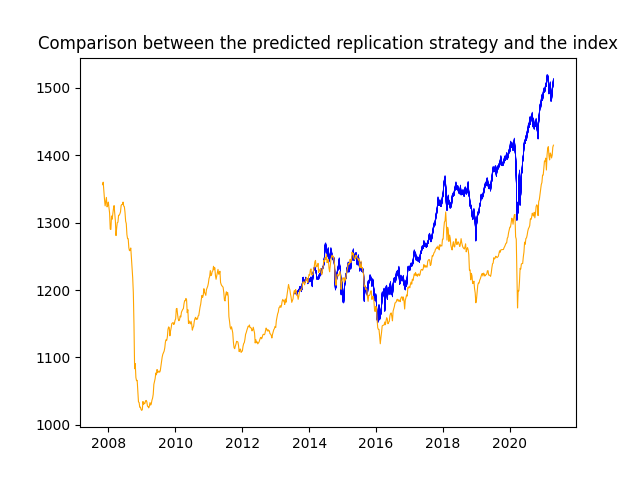

In [15]:
# calculate the log returns of our strategy

for n in range(N_simulations):
    predictions = simulations[n]
    predictions = pd.DataFrame(predictions, columns = df.columns, index = df.index)

    log_ret = np.array(0)
    for index in weights_history.index:
        aux = np.array(predictions.loc[index])
        aux_2 = np.array(df.loc[index])
        log_ret = np.vstack([log_ret, np.dot(aux,aux_2)])
    
    log_ret = log_ret[1:]
    predictions['log_ret'] = log_ret 
    simulations[n] = predictions

# just plot in orange the index and in blue the simulations

%matplotlib notebook
for n in range(N_simulations):
    plt.plot(simulations[n].index[start:], 
             np.exp(simulations[n][start:].log_ret.cumsum())*data.HFRXGL[start],
             lw = 0.5, color = 'blue')
plt.plot(target.index, 
         np.exp(target.HFRXGL.cumsum())*data.HFRXGL[0],
         lw = 0.8, color = 'orange')

plt.title('Comparison between the predicted replication strategy and the index')

plt.show()

#### Weights of the predicted replication strategy

<IPython.core.display.Javascript object>


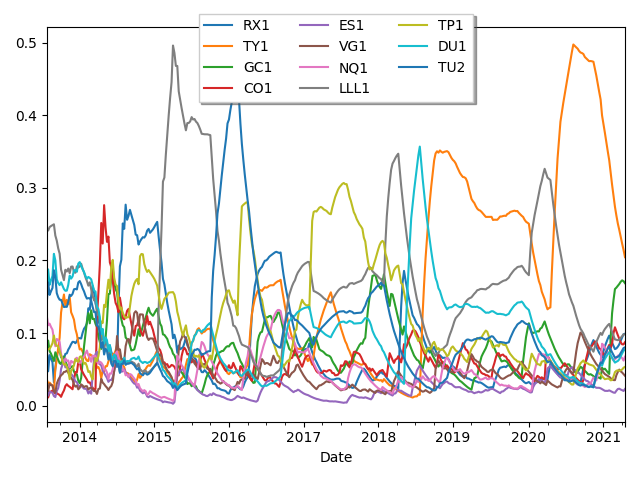

In [16]:
# only one run just to visualize them
%matplotlib notebook
simulations[0].iloc[start:].drop(columns = ['log_ret']).plot()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=False, shadow=True)
plt.tight_layout()
plt.show()

### Analysis of the strategy

In [26]:
# We assume 252 trading days in a year, so 36 trading weeks.

def strat_trading_cost(predictions, trading_cost, df, start):
    data = predictions.drop(columns = ['log_ret'])
    costs = abs(data.diff(1).dropna()).sum().sum()*trading_cost
    years_in_consideration = (df.shape[0]-start)/36.
    return costs/years_in_consideration

def volatility_tracking_error(predictions, target, start):
    return np.std(predictions.iloc[start:]['log_ret']-target.iloc[start:]['HFRXGL'])*np.sqrt(36)

# IR calculated as (annualized returns in % - annualized benchmark returns in %) / volatility of returns (not log-ret)
def IR(simulations, n, target, start):
    annualized_ret_index = np.exp(36./404.*(target.iloc[start:]['HFRXGL'].cumsum())[-1])-1
    annualized_ret_pred = np.exp(36./404.*(simulations[n].iloc[start:]['log_ret'].cumsum())[-1])-1
    aux = np.exp(simulations[n].iloc[start:]['log_ret'])-1.
    aux2 = np.exp(target.iloc[start:]['HFRXGL'])-1.
    TE = np.std(aux-aux2)*np.sqrt(36)
    return (annualized_ret_pred-annualized_ret_index)/TE
    
    
total_trading_cost = 0
total_volatility_TE = 0
total_IR = 0

for n in range(N_simulations):
    predictions = simulations[n]
    total_trading_cost += np.around(strat_trading_cost(predictions, trading_cost, df, start) * 100,
                                    decimals = 4)
    sim_TE = np.around(volatility_tracking_error(predictions, target, start), 
                                    decimals = 4)
    
    total_IR += IR(simulations, n, target, start)
    total_volatility_TE += sim_TE
    

print('The mean trading cost (without initial allocation cost) of the predicted strategy is (per year):' ,total_trading_cost / N_simulations, 
      '%')

print('The mean volatility tracking error of the predicted strategy is (annualized):', total_volatility_TE / N_simulations)

print('The mean IR (respected to HFRXGL index) is:', total_IR / N_simulations)

The mean trading cost (without initial allocation cost) of the predicted strategy is (per year): 0.039105 %
The mean volatility tracking error of the predicted strategy is (annualized): 0.04595500000000002
The mean IR (respected to HFRXGL index) is: 0.12913890161563593
